In [1]:
import sys
# load standard python modules
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

from modules.jet_augs import crop_jets, remove_jet_and_rescale_pT
from modules.neural_net import create_and_run_nn

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.cuda.empty_cache()


from numba import cuda 
device = cuda.get_current_device()
device.reset()


In [2]:
# More parameters / computing setup

# set the number of threads that pytorch will use
torch.set_num_threads(2)

exp_id = "dijet_sim_scan_50_0/1000d/"

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "device: " + str( device ), flush=True)

# set up results directory
base_dir = "/global/home/users/rrmastandrea/MJetCLR/"  # change this to your working directory
expt_dir = base_dir + "projects/rep_learning/experiments/" + exp_id + "/"

#check if experiment alreadyexists
if os.path.isdir(expt_dir):
    print("ERROR: experiment already exists, don't want to overwrite it by mistake")
    pass
else:
    os.makedirs(expt_dir)

print("experiment: "+str(exp_id) , flush=True)


device: cuda
ERROR: experiment already exists, don't want to overwrite it by mistake
experiment: dijet_sim_scan_50_0/1000d/


In [4]:
path_to_save_dir = "/global/home/users/rrmastandrea/training_data/"


save_id_dir = "n_sig_8639_n_bkg_20000_n_nonzero_50_n_pad_0_n_jet_2/"
grading = 50
n_jets = 2

path_to_data = path_to_save_dir+save_id_dir
print(path_to_data)


data_train = np.load(path_to_data+"data_train.npy")
labels_train = np.load(path_to_data+"labels_train.npy")
data_val = np.load(path_to_data+"data_val.npy")
labels_val = np.load(path_to_data+"labels_val.npy")
data_test_f = np.load(path_to_data+"data_test_f.npy")
labels_test_f = np.load(path_to_data+"labels_test_f.npy")

# rescale
data_train = remove_jet_and_rescale_pT(data_train, n_jets)
data_val = remove_jet_and_rescale_pT(data_val, n_jets)
data_test_f = remove_jet_and_rescale_pT(data_test_f, n_jets)

# print data dimensions
print( "BC training data shape: " + str( data_train.shape ), flush=True)
print( "BC training labels shape: " + str( labels_train.shape ), flush=True)
print( "BC val data shape: " + str( data_val.shape ), flush=True)
print( "BC val labels shape: " + str( labels_val.shape ), flush=True)
print( "BC test data shape: " + str( data_test_f.shape ), flush=True)
print( "BC test labels shape: " + str( labels_test_f.shape ), flush=True)


# Plot num constituents

def get_num_constits(dataset):
    consits_list = []
    for collision in dataset:
        pts = collision[0,:]

        pads = np.where(pts==0)
        consits_list.append(dataset.shape[2]-len(pads[0]))
        
    return consits_list
        

/global/home/users/rrmastandrea/training_data/n_sig_8639_n_bkg_20000_n_nonzero_50_n_pad_0_n_jet_2/
BC training data shape: (20047, 3, 100)
BC training labels shape: (20047,)
BC val data shape: (4296, 3, 100)
BC val labels shape: (4296,)
BC test data shape: (4296, 3, 100)
BC test labels shape: (4296,)


# Run final LCT, NN on the constituent representations

(20047, 3, 50)
Doing a LCT...


/global/home/users/rrmastandrea/computingEnv/lib64/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


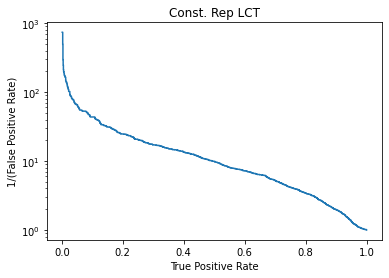

LCT data saved

Doing a NN...
Starting training...


100%|██████████| 400/400 [00:40<00:00,  9.85it/s]


Finished Training


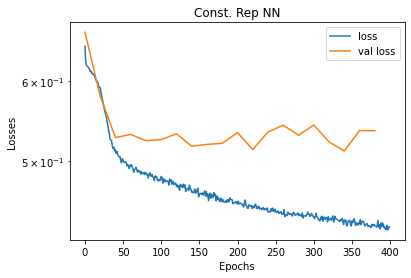

/global/home/users/rrmastandrea/computingEnv/lib64/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide


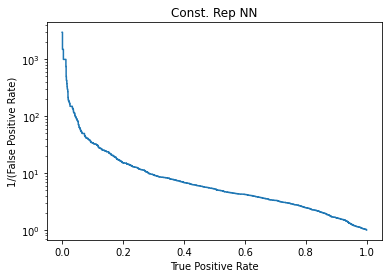

Accuracy of the network: 68 %
ROC AUC: 0.7441677869658798


In [5]:
# with the constituent set (pt, eta, phi)

constit_num = grading

# prepare the data
data_train_nn = crop_jets(data_train, constit_num)
data_val_nn = crop_jets(data_val, constit_num)
data_test_nn = crop_jets(data_test_f, constit_num)

print(data_train_nn.shape)



lct_train = np.reshape(data_train_nn,(data_train_nn.shape[0],3*constit_num))
lct_test = np.reshape(data_test_nn,(data_test_nn.shape[0],3*constit_num))


print("Doing a LCT...")
reg = LinearRegression().fit(lct_train, labels_train)
# make the prediction
predictions = reg.predict(lct_test)
fpr, tpr, _ = roc_curve(labels_test_f, predictions)

plt.figure()
plt.plot(tpr, 1.0/fpr)
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.title("Const. Rep LCT")
plt.show()


np.save( expt_dir+"const_rep_lct_fpr_"+str(constit_num)+".npy", fpr )
np.save( expt_dir+"const_rep_lct_tpr_"+str(constit_num)+".npy", tpr )
print("LCT data saved")

print()

print("Doing a NN...")
num_epochs_nn = 400
batch_size_nn = 400
update_epochs_nn = 20
input_shape = 3*constit_num
#update_epochs_nn = 20
lr_nn = 0.00008

performance_stats_nn = create_and_run_nn(device, input_shape, num_epochs_nn, batch_size_nn, update_epochs_nn,lr_nn, 
                                         data_train_nn, labels_train, 
                      data_val_nn, labels_val,
                      data_test_nn, labels_test_f, True)

# Plot the output losses   
plt.figure()
plt.plot(performance_stats_nn["epochs"],performance_stats_nn["losses"], label = "loss")
plt.plot(performance_stats_nn["val_epochs"],performance_stats_nn["val_losses"], label = "val loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.yscale("log")
plt.legend()
plt.title("Const. Rep NN")
plt.show()

plt.figure()
plt.plot(performance_stats_nn["tpr"], 1.0/performance_stats_nn["fpr"])
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.title("Const. Rep NN")
plt.show()

np.save( expt_dir+"const_rep_nn_tpr_"+str(constit_num)+".npy", performance_stats_nn["tpr"] )
np.save( expt_dir+"const_rep_nn_fpr_"+str(constit_num)+".npy", performance_stats_nn["fpr"] )

print("Accuracy of the network: %d %%" % (100.00 *performance_stats_nn["acc"]))
print("ROC AUC:", performance_stats_nn["auc"])


